In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import random, sys, os
from torch.utils.data import DataLoader
sys.path.append("../..")
# BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
# sys.path.append(BASE_DIR)
from version2.utils import global_var
os.environ["CUDA_VISIBLE_DEVICES"] = '4'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
global_var._init()
global_var.set_value('device', device)
from version2.nets.model import ECGFormer
from version2.data.dataloader2 import get_spectrum_ecg_trainloader, get_spectrum_ecg_testloader
from version2.utils.timestamp_create import create_folder
from version2.utils.log_write import create_log
import neurokit2 as nk
import matplotlib.pyplot as plt
import neurokit2 as nk
from sklearn.metrics import mean_squared_error, r2_score
from utils.train import down_sample
%matplotlib inline

# device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

# os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
# sst_root = "/home/zhangyuanyuan/Dataset/data_MMECG/10Hz_norm/"
# sst_train_root = "/home/zhangyuanyuan/Dataset/data_MMECG/10Hz_norm_train"
# sst_test_root = "/home/zhangyuanyuan/Dataset/data_MMECG/10Hz_norm_test"
# ecg_root = "/home/zhangyuanyuan/Dataset/data_MMECG/data_org"
# peak_root = "/home/zhangyuanyuan/Dataset/data_MMECG/peak_index/"
train_root = "/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_new/train"
test_root = "/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_new/test"

# train_root = "/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_01_norm/train"
# test_root = "/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_01_norm/test"

cuda:0


In [5]:

# state_dict_path="/home/zhangyuanyuan/ECGFormer_/Model_saved/best_model_all_6_ce_.pth"
# state_dict_path="/home/zhangyuanyuan/ECGFormer_/Model_saved/best_model_temp_1_ce_.pth"
state_dict_path="/home/zhangyuanyuan/ECGFormer_/Model_saved/best_model_endless_mse_.pth" # onlyused for old dataset
state_dict_path="/home/zhangyuanyuan/ECGFormer_/Model_saved/best_model_endless_mse_new.pth"
# state_dict_path="/home/zhangyuanyuan/ECGFormer_/Model_saved/best_model_endless_ce_new.pth"
# state_dict_path="/home/zhangyuanyuan/ECGFormer_/Model_saved/best_model_endless_ce_new.pth"
# state_dict_path="/home/zhangyuanyuan/ECGFormer_/Model_saved/best_model_temp_endless_mse_new.pth"


model = ECGFormer(in_channels=50).to(device)
model._initialize_weights()
model.load_state_dict(torch.load(state_dict_path, map_location=device))
model.eval()
# testset = SpectrumECGDataset(sst_root=sst_root, ecg_root=ecg_root, peak_root=peak_root)
def norm_ecg(ECG):
    ECG = (ECG - np.min(ECG)) / (np.max(ECG) - np.min(ECG))
    return ECG
def norm_ecg_11(ECG):
    k=2/(np.max(ECG)-np.min(ECG))
    ECG = -1+k*(ECG-np.min(ECG))
    return ECG

In [6]:
def mu_law(ecg):
    ecg = np.sign(ecg) * np.log(1 + 255 * np.abs(ecg)) / np.log(256)
    return ecg
def inverse_mu_law(ecg):
    ecg = np.sign(ecg) / 255 * ((1 + 255) ** np.abs(ecg) - 1)
    return ecg

In [7]:
# dataloader = get_spectrum_ecg_testloader(sst_root=sst_root, ecg_path=ecg_root, batch_size=1)
dataloader=get_spectrum_ecg_testloader(data_root=test_root, batch_size=1)
# dataloader=get_spectrum_ecg_testloader(data_root=train_root, batch_size=1)

In [8]:
valid_prediction=[]
ECG_gts=[]
ECG_pred=[]
rcgs=[]
ssts=[]
with torch.no_grad():
    validation_loop = tqdm(enumerate(dataloader), total=len(dataloader)) 
    for i, (maps, labels) in validation_loop:
        inputs = maps.to(device)
        gts = labels.to(device)
        tgts = labels.to(device).permute(2, 0, 1)
        predictions = model(inputs)
        ECG_gts.append(labels)
        ECG_pred.append(predictions)
        ssts.append(inputs)
        # if i==30:
        #     break

  0%|          | 0/2204 [00:00<?, ?it/s]/home/zhangyuanyuan/anaconda3/envs/estHR/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643003845/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  2%|▏         | 40/2204 [00:29<26:30,  1.36it/s] 


KeyboardInterrupt: 

1.0
MSE: 0.00029467777
RMSE: 0.01716618


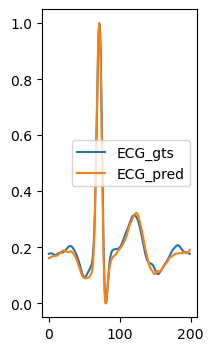

In [ ]:
index=275
index_rcg=20
ecg_gts=norm_ecg(ECG_gts[index].detach().cpu().numpy().squeeze().squeeze())
ecg_pred=norm_ecg(ECG_pred[index].detach().cpu().numpy().squeeze().squeeze()[:200])
plt.figure(figsize=(2,4))
plt.plot((ecg_gts), label='ECG_gts')
plt.plot((ecg_pred), label='ECG_pred')
plt.legend()
plt.style.use('default')
k=1/(np.max(ecg_gts)-np.min(ecg_gts))
mse=mean_squared_error((ecg_gts)/k, (ecg_pred)/k)
print((np.max(ecg_gts)-np.min(ecg_gts)))
print("MSE:",mse)
print("RMSE:",np.sqrt(mse))

In [ ]:
# calculate rmse error for data
rmses = np.array([])
mses = np.array([])
for i in range(0, len(ECG_gts)):
    ecg_gts=ECG_gts[i].detach().cpu().numpy().squeeze()
    ecg_pred=ECG_pred[i].detach().cpu().numpy().squeeze()[:200]
    factor = 1/(np.max(ecg_gts)-np.min(ecg_gts))
    ecg_min = np.min(ecg_gts)
    ecg_gts = norm_ecg(ecg_gts)
    ecg_pred = norm_ecg(ecg_pred)
    mse=mean_squared_error(ecg_gts/factor, ecg_pred/factor)
    mses = np.append(mses, (mse))
    rmses = np.append(rmses, np.sqrt(mse))
print("RMSE Mean:",np.mean(rmses),"Median:",np.median(rmses))

RMSE Mean: 0.0692885079034038 Median: 0.06058994308114052


In [ ]:
print(np.where(rmses==np.max(rmses)))
print(np.where(rmses==np.min(rmses)))

(array([1169]),)
(array([275]),)


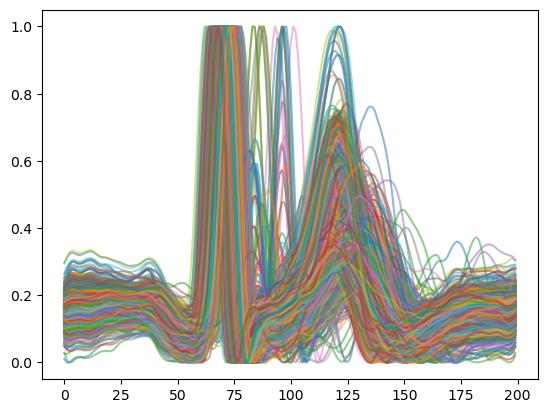

In [ ]:
for i in range(len(ECG_gts)):
    # plt.subplot(1,len(ECG_gts),i+1)
    ecg_gts=ECG_gts[i].detach().cpu().numpy().squeeze()
    ecg_pred=ECG_pred[i].detach().cpu().numpy().squeeze()
    plt.plot(norm_ecg(ecg_pred), alpha=0.5)

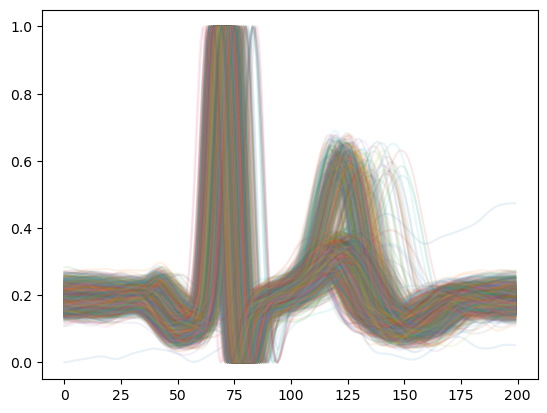

In [ ]:
for i in range(len(ECG_gts)):
    # plt.subplot(1,len(ECG_gts),i+1)
    ecg_gts=ECG_gts[i].detach().cpu().numpy().squeeze()
    # ecg_pred=ECG_pred[i].detach().cpu().numpy().squeeze()
    plt.plot(norm_ecg(ecg_gts), alpha=0.1)